# Project Metrics

In this notebook, we attempt to gather data from our model, training sessions, and experiments to capture the challenges faced and the effort invested in this project.

In [8]:
# project imports
import env
from utils import LOGS_DIR, read_file_contents, read_json_data, flatten_dict
from data import PROCESSED_DIR


# python & package imports
import pandas as pd
import numpy as np
import matplotlib
import datetime
import math
import csv
import os
import re


# plot things
%matplotlib inline
matplotlib.style.use('ggplot')
# autoreload modules
%load_ext autoreload
%autoreload 2


vae_modelnet10_32_dir = '/home/jcworkma/jack/3d-form/models/voxel_vae_modelnet10_200epochs_1'
vae_modelnet10_32_log = '/home/jcworkma/jack/3d-form/src/logs/2019-03-28_15-09__root.log'
#vae_modelnet10_64_dir = '/home/jcworkma/jack/3d-form/models/voxel_vae_modelnet10_64_130epochs'
#vae_modelnet10_64_log = '/home/jcworkma/jack/3d-form/src/logs/2019-04-09_05-32__root.log'
vae_modelnet10_64_dir = '/home/jcworkma/jack/3d-form/models/voxel_vae_modelnet10_64_200epochs'
vae_modelnet10_64_log = '/home/jcworkma/jack/3d-form/src/logs/2019-04-11_19-52__root.log'
vaegan_example_dir = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-20_09-39-05'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Project Data

In order to produce interesting metrics on our project, we need to gather the data. This section builds a dataframe summarizing all experiments that we can analzye.

In [9]:
logs = [os.path.join(LOGS_DIR, l) for l in os.listdir(LOGS_DIR)]
len(logs)

428

In [10]:
# Gather all experiments
# we identify experiments by those that have a saved cfg.json
# other scripts do not operate with cfg.json
re_cfg = re.compile(r'Saved cfg: (.*?cfg\.json)')
re_time = re.compile(r'Elapsed time: (\d+\.\d+) mins')
rows = list()
keys = set()
for log in logs:
    row = dict()
    try:
        contents = read_file_contents(log)
    except:
        print('failed to read {}'.format(log))
        continue
    logtime = datetime.datetime.strptime(os.path.basename(log)[:16], '%Y-%m-%d_%H-%M')
    #Saved cfg: /home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-04-09_04-35-17/cfg.json
    match = re_cfg.search(contents[:1000])
    if match and len(match.group()) > 0:
        cfg_json = match.group(1)
        row['log'] = log
        row['cfg'] = cfg_json
        # if cfg exists, we know its a training session
        if os.path.exists(cfg_json):
            # if vaegan: 1; else if vae 0
            if 'Running VAE-GAN in VAE-Only Mode' in contents:
                row['vaegan'] = False
            else:
                row['vaegan'] = True
            # Elapsed time: 6402.33 mins
            match = re_time.findall(contents[-1000:])
            if match and len(match) > 0:
                row['elapsed_time'] = float(match[-1])
            else:
                row['elapsed_time'] = np.nan
            # flatten cfg, get all values
            cfg_data = read_json_data(cfg_json)
            cfg_data = flatten_dict(cfg_data)
            # merge cfg dict with row dict
            row = {**row, **cfg_data}
        metrics_json = os.path.join(os.path.dirname(cfg_json), 'metrics.json')
        if os.path.exists(metrics_json):
            metrics_data = read_json_data(metrics_json)
            if len(metrics_data) > 0:
                # assuming only keys are epoch\d+
                metrics_keys = [int(key.replace('epoch', '')) for key in metrics_data.keys()]
                last_epoch = sorted(metrics_keys)[-1]
                last_key = 'epoch{}'.format(last_epoch)
                last_epoch_data = metrics_data[last_key]
                row = {**row, **last_epoch_data}
            
        keys = keys.union(set(row.keys()))
        rows.append(row)

# make sure that all rows have all of the keys
for row in rows:
    missing = keys.difference(row)
    for m in missing:
        row[m] = np.nan

print(keys)
len(rows)

{'model/no_gan', 'model/launch_tensorboard', 'model/gpu', 'model/dis_noise', 'enc_loss', 'model/tb_compare', 'model/kl_div_loss_weight', 'model/train_gan_cadence', 'kl_divergence', 'model/train_vae_cadence', 'dis_loss', 'model/input_repeats', 'model/dev_step', 'model/voxel_prob_threshold', 'elapsed_time', 'dataset/index', 'model/tb_dir', 'generator/pad', 'model/save_step', 'generator/verbose', 'model/learning_rate', 'model/ll_weight', 'model/ckpt_dir', 'model/debug', 'model/dec_lr', 'dec_loss', 'model/voxels_dim', 'cfg', 'model/dec_weight', 'vaegan', 'model/batch_size', 'model/epochs', 'dataset/splits', 'model/latent_dim', 'model/recon_loss_weight', 'dataset/categories', 'dataset/class', 'model/keep_prob', 'reconstruction_loss', 'model/display_step', 'model/adaptive_lr', 'model/verbose', 'model/enc_lr', 'log', 'model/monitor_memory', 'll_loss', 'model/dis_lr'}


185

In [11]:
pm_path = os.path.join(PROCESSED_DIR, 'project_metrics.csv')
with open(pm_path, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=keys)
    writer.writeheader()
    for row in rows:
        writer.writerow(row)

In [12]:
df = pd.read_csv(pm_path)
df

,model/no_gan,model/launch_tensorboard,model/gpu,model/dis_noise,enc_loss,model/tb_compare,model/kl_div_loss_weight,model/train_gan_cadence,kl_divergence,model/train_vae_cadence,...,model/keep_prob,reconstruction_loss,model/display_step,model/adaptive_lr,model/verbose,model/enc_lr,log,model/monitor_memory,ll_loss,model/dis_lr
0,False,True,NaN,NaN,NaN,"[['vaegan_100epochs_toilets', '/home/jcworkma/...",100.0,1.0,NaN,2.0,...,1.0,NaN,1.0,NaN,True,0.0002,/home/jcworkma/jack/3d-form/src/logs/2019-03-1...,True,NaN,0.0002
1,True,True,NaN,0.00,NaN,"[['vae_toilet_nightstand_monitor', '/home/jcwo...",0.1,1.0,NaN,1.0,...,0.8,NaN,1.0,False,True,0.0001,/home/jcworkma/jack/3d-form/src/logs/2019-04-0...,True,NaN,0.0001
2,False,True,NaN,0.05,15.493162,"[['vaegan_1024_filter_discr', '/home/jcworkma/...",100.0,1.0,1.419442e-03,1.0,...,0.8,0.412828,1.0,False,True,0.0001,/home/jcworkma/jack/3d-form/src/logs/2019-03-2...,True,1.535122e+05,0.0001
3,False,True,NaN,NaN,NaN,"[['first_vaegan', '/home/jcworkma/jack/3d-form...",1.0,NaN,NaN,NaN,...,0.8,NaN,6000.0,NaN,True,0.0001,/home/jcworkma/jack/3d-form/src/logs/2019-03-1...,NaN,NaN,0.0001
4,True,True,NaN,0.00,78.337311,"[['voxel_vae_toilet_200epochs_1', '/home/jcwor...",0.1,1.0,2.072665e+02,1.0,...,0.8,0.005777,1.0,False,True,0.0001,/home/jcworkma/jack/3d-form/src/logs/2019-03-2...,True,-9.990000e+02,0.0001
5,False,True,NaN,NaN,NaN,"[['best_sofa_and_toilet', '/home/jcworkma/jack...",1.0,NaN,NaN,NaN,...,0.8,NaN,6000.0,NaN,True,NaN,/home/jcworkma/jack/3d-form/src/logs/2019-03-1...,NaN,NaN,NaN
6,False,True,NaN,NaN,NaN,"[['vaegan_100epochs_toilets', '/home/jcworkma/...",100.0,NaN,NaN,NaN,...,1.0,NaN,1.0,NaN,True,0.0001,/home/jcworkma/jack/3d-form/src/logs/2019-03-1...,True,NaN,0.0001
7,True,True,NaN,NaN,NaN,"[['best', '/home/jcworkma/jack/3d-form/models/...",1.0,NaN,NaN,NaN,...,0.8,NaN,6000.0,NaN,True,NaN,/home/jcworkma/jack/3d-form/src/logs/2019-03-1...,NaN,NaN,NaN
8,False,True,NaN,NaN,NaN,"[['best_sofa_and_toilet', '/home/jcworkma/jack...",1.0,NaN,NaN,NaN,...,0.8,NaN,6000.0,NaN,True,NaN,/home/jcworkma/jack/3d-form/src/logs/2019-03-1...,NaN,NaN,NaN
9,False,True,NaN,NaN,19.571060,"[['best_vaegan', '/home/jcworkma/jack/3d-form/...",100.0,NaN,8.224614e-02,NaN,...,1.0,0.107949,1.0,NaN,True,0.0001,/home/jcworkma/jack/3d-form/src/logs/2019-03-1...,True,1.134644e+04,0.0001


## Compute System

For the majority of training, a system with this configuration was used:

* Memory: 64 GB
* Processor: Intel Core i9-7900X CPU @ 3.30GHz x 20
* Disk: 1.0 TB

For the 64x64x64 model, we added the following graphics card to the system:

* NVIDIA GeForce GTX 1060 6GB

## Model Definition

In [13]:
# tbd while gpu model trains

## Training Times

Total Training Time: 534.17 hours
Total Training Time: 22.26 days


VAEGAN    129.851978
VAE       404.317358
Name: elapsed_time, dtype: float64

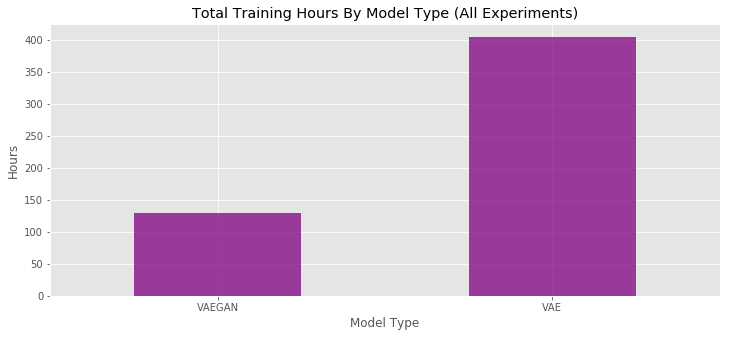

In [14]:
grouped = df.groupby('model/no_gan')['elapsed_time'].sum()
grouped = grouped / 60
grouped.index =['VAEGAN', 'VAE']
ax = grouped.plot.bar(title='Total Training Hours By Model Type (All Experiments)', alpha=0.75, color='purple', rot=0, figsize=(12, 5))
ax.set_xlabel('Model Type')
ax.set_ylabel('Hours')
print('Total Training Time: {:.2f} hours'.format(grouped.sum()))
print('Total Training Time: {:.2f} days'.format(grouped.sum() / 24))
grouped

In [15]:
df[df.log == vae_modelnet10_32_log]

,model/no_gan,model/launch_tensorboard,model/gpu,model/dis_noise,enc_loss,model/tb_compare,model/kl_div_loss_weight,model/train_gan_cadence,kl_divergence,model/train_vae_cadence,...,model/keep_prob,reconstruction_loss,model/display_step,model/adaptive_lr,model/verbose,model/enc_lr,log,model/monitor_memory,ll_loss,model/dis_lr
105,True,True,NaN,0.0,45.391586,"[['vae_toilet_nightstand_monitor', '/home/jcwo...",0.1,1.0,156.034073,1.0,...,0.8,0.002977,1.0,False,True,0.0001,/home/jcworkma/jack/3d-form/src/logs/2019-03-2...,True,-999.0,0.0001


In [16]:
def calc_avg_epoch_time(model_dir, num_epochs):
    metrics32 = os.path.join(model_dir, 'metrics.json')
    mjson = read_json_data(metrics32)
    times = [mjson['epoch{}'.format(e)]['elapsed_time'] for e in range(num_epochs)]
    times_m1 = [times[i] - times[i-1] for i in range(len(times))[1:]]
    avg_epoch_time = sum(times_m1) / len(times_m1)
    return avg_epoch_time

def calc_avg_batch_time(avg_epoch_time, modeldir):
    cfg = read_json_data(os.path.join(modeldir, 'cfg.json'))
    dataset_size = len(pd.read_csv(cfg['dataset']['index']))
    batch_size = cfg['model']['batch_size']
    num_batches = math.ceil(dataset_size / batch_size)
    avg_batch_time = avg_epoch_time / num_batches
    return avg_batch_time

def total_training_time(modeldir):
    metrics_data = read_json_data(os.path.join(modeldir, 'metrics.json'))
    metrics_keys = [int(key.replace('epoch', '')) for key in metrics_data.keys()]
    last_epoch = sorted(metrics_keys)[-1]
    last_key = 'epoch{}'.format(last_epoch)
    last_epoch_data = metrics_data[last_key]
    print(last_key)
    return last_epoch_data['elapsed_time'] / 60 / 24
            


print('Avg Epoch Times')
avg_epoch32 = calc_avg_epoch_time(vae_modelnet10_32_dir, 200)
avg_epoch64 = calc_avg_epoch_time(vae_modelnet10_64_dir, 130)
avg_epochgan = calc_avg_epoch_time(vaegan_example_dir, 39)
print('\tModelNet10 32: {:.2f} mins'.format(avg_epoch32))
print('\tModelNet10 64: {:.2f} mins'.format(avg_epoch64))
print('\tVoxel Vaegan: {:.2f} mins'.format(avg_epochgan))
print()
print('Avg Batch Times')
print('\tModelNet10 32: {:.2f} mins'.format(calc_avg_batch_time(avg_epoch32, vae_modelnet10_32_dir)))
print('\tModelNet10 64: {:.2f} mins'.format(calc_avg_batch_time(avg_epoch64, vae_modelnet10_64_dir)))
print('\tVoxel Vaegan: {:.2f} mins'.format(calc_avg_batch_time(avg_epochgan, vaegan_example_dir)))
print()
print('Total Training Time')
print('\tModelNet10 32: {:.2f} days'.format(total_training_time(vae_modelnet10_32_dir)))
print('\tModelNet10 64: {:.2f} days'.format(total_training_time(vae_modelnet10_64_dir)))
print('\tVoxel Vaegan: {:.2f} days'.format(total_training_time(vaegan_example_dir)))


Avg Epoch Times
	ModelNet10 32: 31.85 mins
	ModelNet10 64: 30.95 mins
	Voxel Vaegan: 31.65 mins

Avg Batch Times
	ModelNet10 32: 0.05 mins
	ModelNet10 64: 0.01 mins
	Voxel Vaegan: 0.14 mins

Total Training Time
epoch200
	ModelNet10 32: 4.45 days
epoch199
	ModelNet10 64: 4.29 days
epoch39
	Voxel Vaegan: 0.88 days


## Shapes Processed

Here we review the experiments to determine how many shapes we trained in total and for the final model.

In [146]:
df.columns

Index(['kl_divergence', 'model/train_gan_cadence', 'enc_loss',
       'model/display_step', 'model/dis_noise', 'dec_loss', 'model/debug',
       'dataset/index', 'model/keep_prob', 'dataset/splits', 'model/save_step',
       'model/monitor_memory', 'model/verbose', 'dis_loss', 'vaegan',
       'model/recon_loss_weight', 'model/dec_weight', 'reconstruction_loss',
       'model/input_repeats', 'model/ll_weight', 'model/voxels_dim',
       'model/learning_rate', 'dataset/class', 'generator/pad', 'model/epochs',
       'log', 'cfg', 'model/ckpt_dir', 'dataset/categories', 'll_loss',
       'model/kl_div_loss_weight', 'model/dev_step', 'model/dis_lr',
       'model/enc_lr', 'model/batch_size', 'model/latent_dim',
       'model/voxel_prob_threshold', 'model/train_vae_cadence', 'elapsed_time',
       'model/gpu', 'model/launch_tensorboard', 'model/tb_compare',
       'model/tb_dir', 'model/no_gan', 'generator/verbose', 'model/dec_lr',
       'model/adaptive_lr'],
      dtype='object')

In [147]:
df['dataset/index'].unique()

array(['/home/jcworkma/jack/3d-form/src/../data/processed/modelnet10_toilet_index.csv',
       '/home/jcworkma/jack/3d-form/src/../data/processed/modelnet10_index.csv',
       '/home/jcworkma/jack/3d-form/src/../data/processed/modelnet10_sofa_index.csv',
       '/home/jcworkma/jack/3d-form/src/../data/processed/modelnet10_sofa-toilet_index.csv',
       '/home/jcworkma/jack/3d-form/src/../data/processed/modelnet10_64_index.csv',
       nan], dtype=object)

In [184]:
len(df)

179

### VAEGAN

In [195]:
df_filled = df.fillna(-1)
#df_filled[df_filled['model/no_gan'] == False][[c for c in df.columns if 'model' not in c and 'dataset' not in c]].sort_values('elapsed_time', ascending=False)
df_filled[df_filled['model/no_gan'] == False][['cfg', 'model/epochs', 'elapsed_time']].sort_values('elapsed_time', ascending=False).iloc[0]

cfg             /home/jcworkma/jack/3d-form/src/../models/voxe...
model/epochs                                                  201
elapsed_time                                              1266.07
Name: 177, dtype: object

In [ ]:
df_vaegan = df